# Outlining some pre-processing

In [107]:
%load_ext jupyter_black
import os
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from ochanticipy import GeoBoundingBox

load_dotenv()

pd.set_option("display.float_format", lambda x: "%.5f" % x)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [82]:
# gis_dir = Path(os.getenv("STORM_DATA_DIR")) / "gis files/"
FJI_CRS = "+proj=longlat +ellps=WGS84 +lon_wrap=180 +datum=WGS84 +no_defs"
input_dir = (
    Path(os.getenv("STORM_DATA_DIR"))
    / "analysis/02_new_model_input_fji/02_housing_damage/input/"
)
output_dir = (
    Path(os.getenv("STORM_DATA_DIR"))
    / "analysis/02_new_model_input_fji/02_housing_damage/output/"
)
adm3_shp = gpd.read_file(input_dir / "fji_polbnda_adm3_tikina.zip")
adm3_shp = adm3_shp.set_crs("EPSG:3832")
# +lon_wrap=180 is needed to deal with Fiji crossing antimeridian
adm3_shp = adm3_shp.to_crs(crs=FJI_CRS)

In [7]:
fji_east_bld = gpd.read_file(
    input_dir / "hotosm_fji_east_buildings_polygons_shp.zip"
)
fji_west_bld = gpd.read_file(
    input_dir / "hotosm_fji_west_buildings_polygons_shp.zip"
)

In [9]:
fji_bld = pd.concat([fji_east_bld, fji_west_bld])

<Axes: >

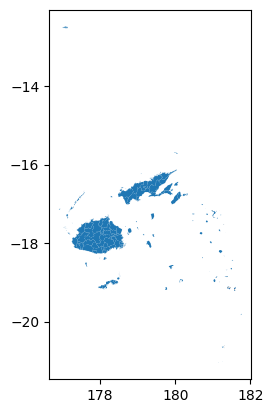

In [53]:
adm3_shp.loc[:, "geometry"].plot()

In [54]:
print(adm3_shp.total_bounds)

[176.88805955 -21.04145368 181.76993845 -12.47952953]


## Creation of grid

In [57]:
# grid creation
xmin, ymin, xmax, ymax = adm3_shp.total_bounds
print([xmin, xmax])

cell_size = 0.1

cols = list(np.arange(xmin, xmax + cell_size, cell_size))
rows = list(np.arange(ymin, ymax + cell_size, cell_size))
rows.reverse()
# using list comprehension instead of loop
polygons = [
    Polygon(
        [
            (x, y),
            (x + cell_size, y),
            (x + cell_size, y - cell_size),
            (x, y - cell_size),
        ]
    )
    for x in cols
    for y in rows
]
grid = gpd.GeoDataFrame({"geometry": polygons}, crs=adm3_shp.crs)
grid["id"] = grid.index + 1
# grid.to_crs(epsg=4326, inplace=True)
grid.head()

[176.88805955426506, 181.76993845011103]


,geometry,id
0,"POLYGON ((176.88806 -12.44145, 176.98806 -12.4...",1
1,"POLYGON ((176.88806 -12.54145, 176.98806 -12.5...",2
2,"POLYGON ((176.88806 -12.64145, 176.98806 -12.6...",3
3,"POLYGON ((176.88806 -12.74145, 176.98806 -12.7...",4
4,"POLYGON ((176.88806 -12.84145, 176.98806 -12.8...",5


<Axes: >

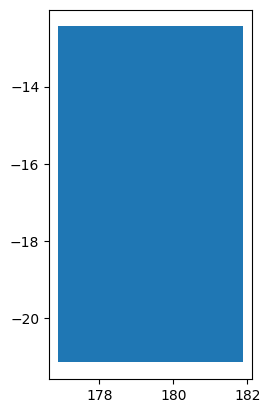

In [58]:
grid.loc[:, "geometry"].plot()

In [59]:
# write as geopackage
grid.to_file(output_dir / "fji_0.1_degree_grid.gpkg", driver="GPKG")

## Creation of centroids

In [60]:
# creating centroids
# Grid
# Extract lat and lon from the centerpoint
grid["Longitude"] = grid["geometry"].centroid.map(lambda p: p.x)
grid["Latitude"] = grid["geometry"].centroid.map(lambda p: p.y)
grid["Centroid"] = (
    round(grid["Longitude"], 2).astype(str)
    + "E"
    + "_"
    + +round(grid["Latitude"], 2).astype(str)
    + "N"
)
grid.head(5)

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_45665/2061595231.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["Longitude"] = grid["geometry"].centroid.map(lambda p: p.x)
/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_45665/2061595231.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["Latitude"] = grid["geometry"].centroid.map(lambda p: p.y)


,geometry,id,Longitude,Latitude,Centroid
0,"POLYGON ((176.88806 -12.44145, 176.98806 -12.4...",1,176.93806,-12.49145,176.94E_-12.49N
1,"POLYGON ((176.88806 -12.54145, 176.98806 -12.5...",2,176.93806,-12.59145,176.94E_-12.59N
2,"POLYGON ((176.88806 -12.64145, 176.98806 -12.6...",3,176.93806,-12.69145,176.94E_-12.69N
3,"POLYGON ((176.88806 -12.74145, 176.98806 -12.7...",4,176.93806,-12.79145,176.94E_-12.79N
4,"POLYGON ((176.88806 -12.84145, 176.98806 -12.8...",5,176.93806,-12.89145,176.94E_-12.89N


/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_45665/710311070.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroids["geometry"] = grid_centroids["geometry"].centroid


<Axes: >

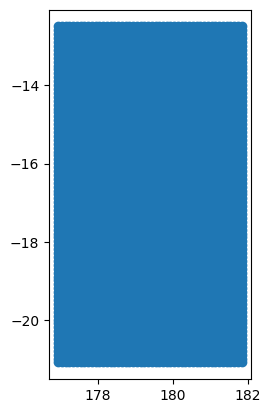

In [61]:
# Centroids
grid_centroids = grid.copy()
grid_centroids["geometry"] = grid_centroids["geometry"].centroid
grid_centroids.loc[:, "geometry"].plot()

In [62]:
# write as geopackage
grid_centroids.to_file(
    output_dir / "fji_0.1_degree_grid_centroids.gpkg", driver="GPKG"
)

In [63]:
# building centroids
fji_bld_centroids = fji_bld.copy()
fji_bld_centroids["geometry"] = fji_bld_centroids["geometry"].centroid

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_45665/1343107964.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fji_bld_centroids["geometry"] = fji_bld_centroids["geometry"].centroid


In [64]:
fji_bld_centroids.to_file(input_dir / "fji_bld_centroids.gpkg", driver="GPKG")

## Intersection of grid and admin shapefile

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_45665/1463734603.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  adm3_grid_intersection = gpd.overlay(adm3_shp, grid, how="identity")


(177.0, 178.0, -18.0, -17.0)

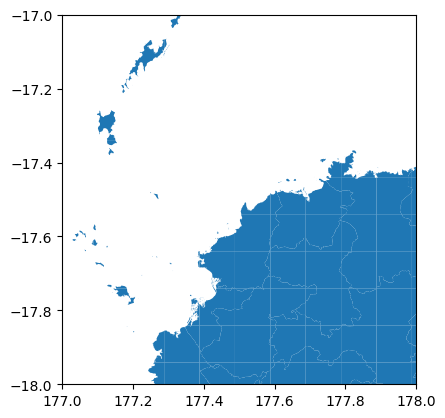

In [66]:
# intersection of grid and shapefile
adm3_grid_intersection = gpd.overlay(adm3_shp, grid, how="identity")
# adm3_grid_intersection = gpd.sjoin(adm3_shp, grid)
adm3_grid_intersection.loc[:, "geometry"].plot()
plt.axis([177, 178, -18, -17])

In [67]:
adm3_grid_intersection = adm3_grid_intersection.dropna(subset=["id"])

In [68]:
adm3_grid_intersection.to_file(
    input_dir / "fji_adm3_grid_intersection.gpkg", driver="GPKG"
)

### For only grids that overlap with land

In [69]:
grid_land_overlap = grid.loc[grid["id"].isin(adm3_grid_intersection["id"])]

In [70]:
grid_land_overlap.to_file(
    output_dir / "fji_0.1_degree_grid_land_overlap.gpkg", driver="GPKG"
)

In [71]:
grid_land_overlap_centroids = grid_centroids.loc[
    grid["id"].isin(adm3_grid_intersection["id"])
]

In [72]:
grid_land_overlap_centroids.to_file(
    output_dir / "fji_0.1_degree_grid_centroids_land_overlap.gpkg",
    driver="GPKG",
)

## Area Computation

In [73]:
# computing areas
adm3_shp_area = adm3_shp.copy()
adm3_shp_area = adm3_shp_area.to_crs({"proj": "cea"})
adm3_shp_area["Area"] = adm3_shp_area["geometry"].area
adm3_shp_area["Area"].describe()

count             86.00000
mean     12720816550.47531
std      81971902662.11478
min          3168453.34234
25%         37235009.99980
50%        159253287.26439
75%        381064933.97584
max     734881818096.92651
Name: Area, dtype: float64

In [74]:
adm3_shp_area.to_csv(input_dir / "adm3_area.csv")

In [75]:
grid_area = grid.copy()
grid_area = grid_area.to_crs({"proj": "cea"})
grid_area["Area_2"] = grid_area["geometry"].area
grid_area["Area_2"].describe()

count           4350.00000
mean      8599281617.91451
std      59381827375.89362
min        115043895.02435
25%        116623891.14391
50%        118034653.66286
75%        119274547.69812
max     432787837634.30237
Name: Area_2, dtype: float64

In [76]:
adm3_grid_intersection_area = adm3_grid_intersection.copy()
adm3_grid_intersection_area = adm3_grid_intersection_area.to_crs(
    {"proj": "cea"}
)
adm3_grid_intersection_area["Area_3"] = adm3_grid_intersection_area[
    "geometry"
].area
adm3_grid_intersection_area["Area_3"].describe()

count            660.00000
mean      1659924763.48246
std      20458864900.18537
min             1350.17484
25%          2862465.88664
50%         13757902.84053
75%         44263435.63634
max     424395917772.85736
Name: Area_3, dtype: float64

In [77]:
# merge
fji_adm3_grid_intersections_area = adm3_shp_area.merge(
    grid_area.merge(
        adm3_grid_intersection_area, on="id", suffixes=(None, "_3")
    ),
    on="ADM3_PCODE",
    suffixes=(None, "_2"),
)

fji_adm3_grid_intersections_area.drop(
    fji_adm3_grid_intersections_area.filter(regex="geometry").columns,
    axis=1,
    inplace=True,
)

In [78]:
fji_adm3_grid_intersections_area.to_csv(
    input_dir / "fji_adm3_grid_intersections_area.csv"
)

## Building Count

### Assigning Buildings to Grids

In [79]:
fji_bld_centroids["random_id"] = fji_bld_centroids.reset_index().index + 1

In [84]:
fji_bld_centroids = fji_bld_centroids.to_crs(FJI_CRS)
fji_bld_centroid_grid_count = (
    grid_land_overlap.sjoin(fji_bld_centroids, how="left")
    .groupby(["id", "Centroid"])
    .count()
    .rename(columns={"random_id": "numbuildings"})
    .reset_index()[["id", "Centroid", "numbuildings"]]
)

In [86]:
fji_bld_centroid_grid_count.to_csv(
    input_dir / "fji_hotosm_bld_centroid_grid_count.csv"
)

In [88]:
fji_bld_centroid_grid_count.head(8)

,id,Centroid,numbuildings
0,47,176.94E_-17.09N,63
1,48,176.94E_-17.19N,150
2,88,177.04E_-12.49N,0
3,139,177.04E_-17.59N,355
4,175,177.14E_-12.49N,0
5,222,177.14E_-17.19N,65
6,223,177.14E_-17.29N,701
7,224,177.14E_-17.39N,109


In [90]:
# this number if slightly higher than the municipality count
# there are some buildings in the ocean and are in grids
# not municipalities which should be fixed.
fji_bld_centroid_grid_count["numbuildings"].sum()

258906

### Testing new way of counting buildings

In [91]:
# assigning buildings to municipalities
fji_bld_centroid_municip_count = (
    adm3_shp.sjoin(fji_bld_centroids, how="left")
    .groupby("ADM3_PCODE")
    .count()
    .rename(columns={"random_id": "numbuildings"})
    .reset_index()[["ADM3_PCODE", "numbuildings"]]
)

In [92]:
fji_bld_centroid_municip_count["numbuildings"].sum()

254607

In [94]:
fji_bld_centroid_municip_count[
    fji_bld_centroid_municip_count["ADM3_PCODE"] == "FJ41204"
]

,ADM3_PCODE,numbuildings
78,FJ41204,18980


In [95]:
fji_bld_centroid_municip_count.to_csv(
    input_dir / "fji_hotosm_bld_centroid_municip_count.csv"
)

In [96]:
fji_bld_centroid_municip_count["numbuildings"].sum()
len(fji_bld_centroid_municip_count["ADM3_PCODE"].unique())

86

In [97]:
# assigning buildings to intersections
fji_bld_centroid_municip_intersection_count = (
    adm3_grid_intersection.sjoin(fji_bld_centroids, how="left")
    .groupby(["ADM3_PCODE", "id", "Centroid"])
    .count()
    .rename(columns={"random_id": "numbuildings"})
    .reset_index()[["ADM3_PCODE", "id", "Centroid", "numbuildings"]]
)

In [99]:
fji_bld_centroid_municip_intersection_count[
    fji_bld_centroid_municip_intersection_count["ADM3_PCODE"] == "FJ41204"
]

,ADM3_PCODE,id,Centroid,numbuildings
589,FJ41204,1188,178.24E_-18.09N,53
590,FJ41204,1189,178.24E_-18.19N,22
591,FJ41204,1274,178.34E_-17.99N,0
592,FJ41204,1275,178.34E_-18.09N,1757
593,FJ41204,1276,178.34E_-18.19N,21
594,FJ41204,1361,178.44E_-17.99N,0
595,FJ41204,1362,178.44E_-18.09N,14214
596,FJ41204,1363,178.44E_-18.19N,2913


In [100]:
fji_bld_centroid_municip_intersection_count.to_csv(
    input_dir / "fji_hotosm_bld_centroid_municip_intersection_count.csv"
)

In [101]:
fji_bld_centroid_municip_intersection_count.shape
len(fji_bld_centroid_municip_intersection_count["ADM3_PCODE"].unique())

86

In [102]:
fji_bld_centroid_municip_intersection_count["numbuildings"].sum()

254607

In [104]:
fji_bld_weight_matrix = fji_bld_centroid_municip_count.merge(
    fji_bld_centroid_municip_intersection_count,
    on="ADM3_PCODE",
    suffixes=(None, "_y"),
)
fji_bld_weight_matrix["weight"] = np.where(
    fji_bld_weight_matrix["numbuildings_y"] == 0,
    0,
    fji_bld_weight_matrix["numbuildings_y"]
    / fji_bld_weight_matrix["numbuildings"],
)

In [105]:
fji_bld_weight_matrix["weight"].describe()

count   660.00000
mean      0.11667
std       0.18483
min       0.00000
25%       0.00040
50%       0.03470
75%       0.15340
max       1.00000
Name: weight, dtype: float64

In [106]:
fji_bld_weight_matrix[["ADM3_PCODE", "id", "Centroid", "weight"]].to_csv(
    input_dir / "fji_bld_weight_matrix.csv"
)